# 自动微分(Automatic Differentiation)简介——tensorflow核心原理
https://blog.csdn.net/aws3217150/article/details/70214422

https://gitee.com/Carl-Xie/AutodiffEngine

现代深度学习系统中（比如MXNet， TensorFlow等）都用到了一种技术——自动微分。在此之前，机器学习社区中很少发挥这个利器，一般都是用Backpropagation进行梯度求解，然后进行SGD等进行优化更新。手动实现过backprop算法的同学应该可以体会到其中的复杂性和易错性，一个好的框架应该可以很好地将这部分难点隐藏于用户视角，而自动微分技术恰好可以优雅解决这个问题。接下来我们将一起学习这个优雅的技术:-)。本文主要来源于陈天奇在华盛顿任教的课程[CSE599G1: Deep Learning System](http://dlsys.cs.washington.edu/schedule)和[《Automatic differentiation in machine learning: a survey》](https://arxiv.org/pdf/1502.05767.pdf)。

## 什么是自动微分

微分求解大致可以分为4种方式：

* 手动求解法(Manual Differentiation)
* 数值微分法(Numerical Differentiation)
* 符号微分法(Symbolic Differentiation)
* 自动微分法(Automatic Differentiation)

为了讲明白什么是自动微分，我们有必要了解其他方法，做到有区分有对比，从而更加深入理解自动微分技术。
### 手动求解法

手动求解其实就对应我们传统的backprop算法，我们求解出梯度公式，然后编写代码，代入实际数值，得出真实的梯度。在这样的方式下，每一次我们修改算法模型，都要修改对应的梯度求解算法，因此没有很好的办法解脱用户手动编写梯度求解的代码，这也是为什么我们需要自动微分技术的原因。
### 数值微分法

数值微分法是根据导数的原始定义： 

$$f′(x)=\lim_{h\to0}\frac{f(x+h)−f(x)}{h}$$


那么只要hh取很小的数值，比如0.0001，那么我们可以很方便求解导数，并且可以对用户隐藏求解过程，用户只要给出目标函数和要求解的梯度的变量，程序可以自动给出相应的梯度，这也是某种意义上的“自动微分”:-)。不幸的是，数值微分法计算量太大，求解速度是这四种方法中最慢的，更加雪上加霜的是，它引起的**roundoff error**和**truncation error**使其更加不具备实际应用场景，为了弥补缺点，便有如下center difference approximation： 

$$f′(x)=\lim_{h\to0}\frac{f(x+h)−f(x-h)}{2h}$$


可惜并不能完全消除truncation error，只是将误差减小。虽然数值微分法有如上缺点，但是由于它实在是太简单实现了，于是很多时候，我们利用它来检验其他算法的正确性，比如在实现backprop的时候，我们用的”gradient check”就是利用数值微分法。

### 符号微分法

符号微分是代替我们第一种手动求解法的过程，利用代数软件，实现微分的一些公式比如： 

$$\frac{d}{dx}(f(x)+g(x))=\frac{d}{dx}f(x)+\frac{d}{dx}g(x)$$
$$\frac{d}{dx}(f(x)*g(x))=g(x)\frac{d}{dx}f(x)+f(x)\frac{d}{dx}g(x)$$
$$\frac{d}{dx}\frac{f(x)}{g(x)}=\frac{f'(x)g(x)-f(x)g'(x)}{g(x)^2}$$

然后对用户提供的具有closed form的数学表达式进行“自动微分”求解，
#### closed form
什么是具有closed form的呢？

也就是必须能写成完整数学表达式的，不能有编程语言中的循环结构，条件结构等。因此如果能将问题转化为一个纯数学符号问题，我们能利用现有的代数软件进行符号微分求解，这种程度意义上的“自动微分”其实已经很完美了。

然而缺点我们刚刚也提及过了，就是必须要有closed form的数学表达式，另一个有名的缺点是“表达式膨胀”（expression swell）问题，如果不加小心就会使得问题符号微分求解的表达式急速“膨胀”，导致最终求解速度变慢，对于这个问题请看如下图： 

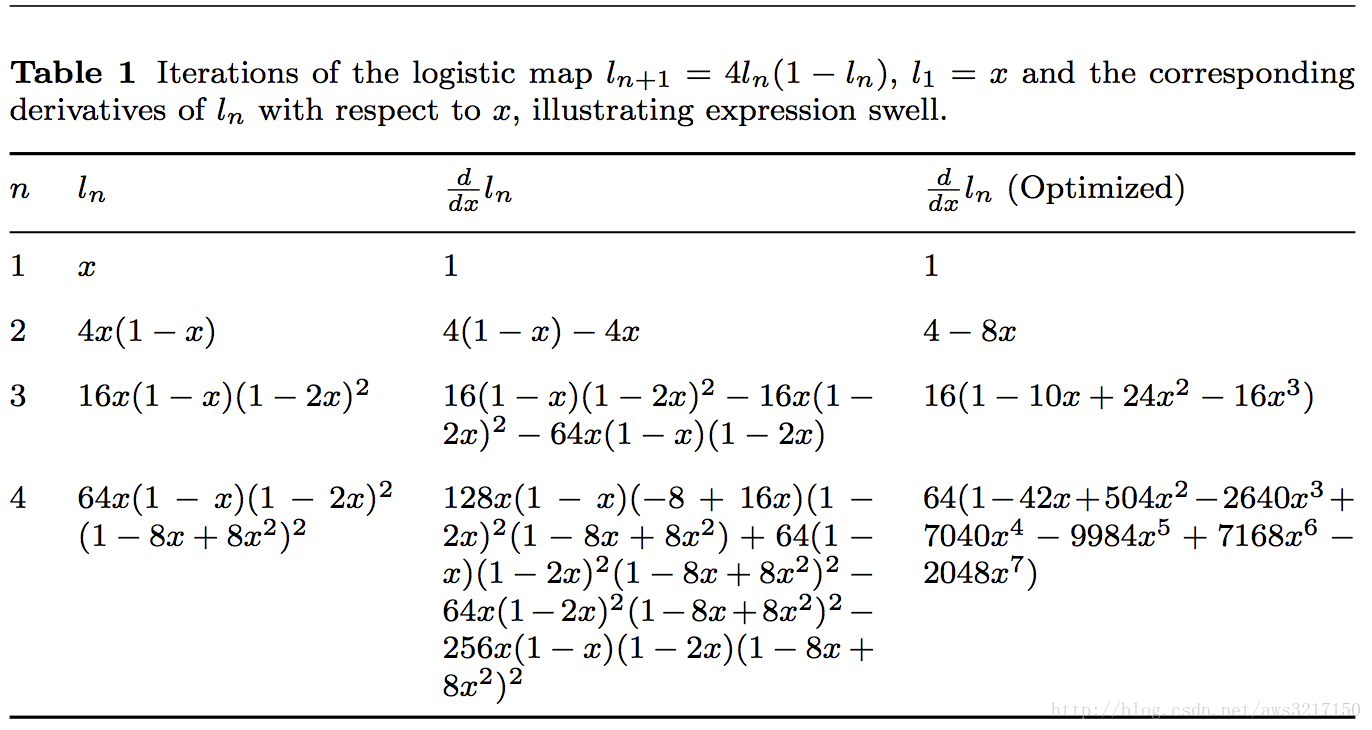

# 自动微分法

终于轮到我们的主角登场，自动微分的存在依赖于它识破如下事实：

**所有数值计算归根结底是一系列有限的可微算子的组合**

自动微分法是一种介于符号微分和数值微分的方法：

数值微分强调一开始直接代入数值近似求解；

符号微分强调直接对代数进行求解，最后才代入问题数值；

自动微分将符号微分法应用于最基本的算子，比如常数，幂函数，指数函数，对数函数，三角函数等，然后代入数值，保留中间结果，最后再应用于整个函数。

因此它应用相当灵活，可以做到完全向用户隐藏微分求解过程，由于它只对基本函数或常数运用符号微分法则，所以它可以灵活结合编程语言的循环结构，条件结构等，使用自动微分和不使用自动微分对代码总体改动非常小，并且由于它的计算实际是一种图计算，可以对其做很多优化，这也是为什么该方法在现代深度学习系统中得以广泛应用。

## 自动微分Forward Mode
考察如下函数： 

$f(x1,x2)=ln(x1)+x1x2−sin(x2)$


我们可以将其转化为如下计算DAG（有向无环图）结构，之后可以很容易分步计算函数的值，并求取它每一步的导数值：
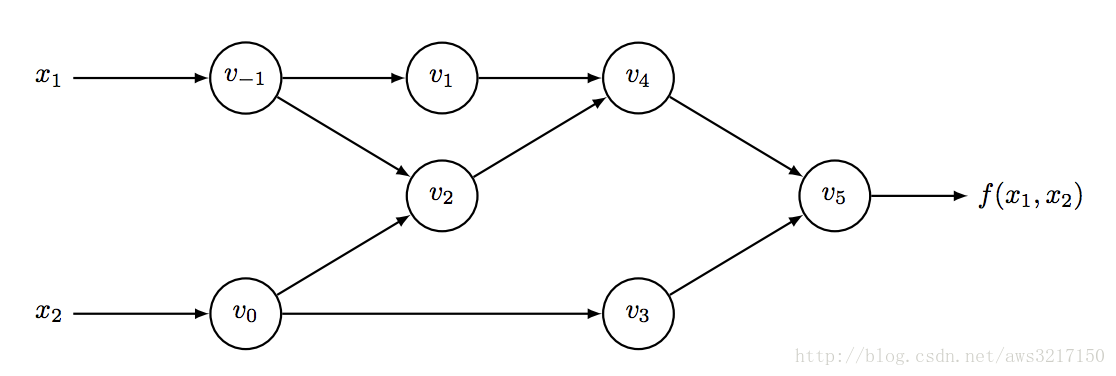

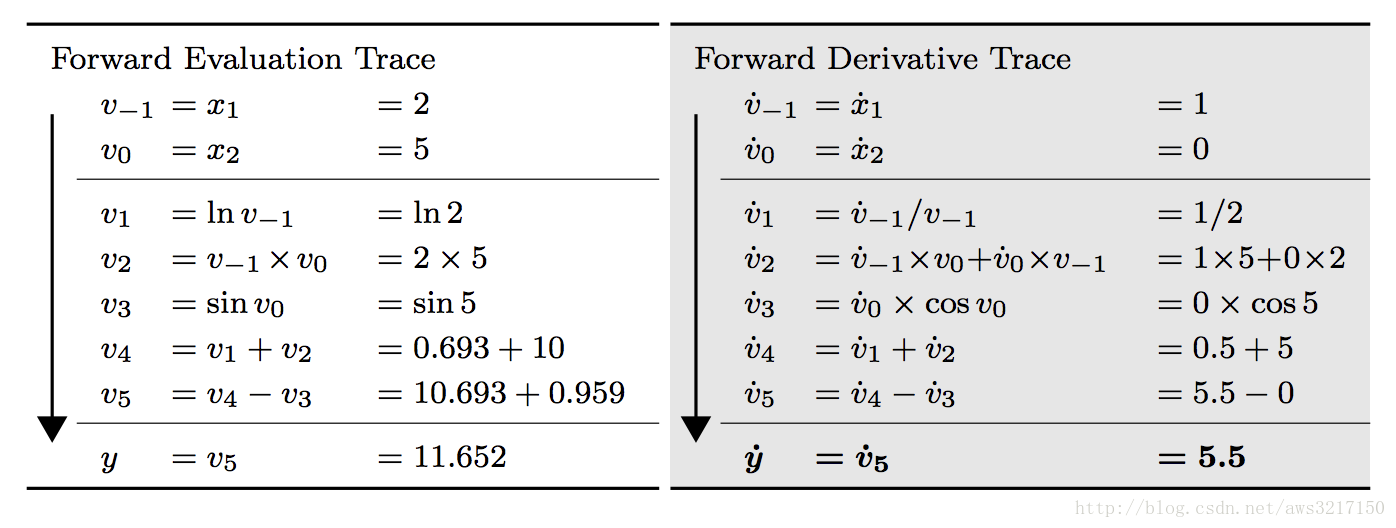

上表中左半部分是从左往右每个图节点的求值结果，右半部分是每个节点对于$x1$的求导结果，注意到每一步的求导都利用到上一步的求导结果，这样不至于重复计算，因此也不会产生像符号微分法的”expression swell”问题。 

自动微分的forward mode非常符合我们高数里面学习的求导过程，只要您对求导法则还有印象，理解forward mode自不在话下。如果函数输入输出为： 

$$R→R^m$$


那么利用forward mode只需计算一次如上表右边过程即可，非常高效。对于输入输出映射为如下的： 

$$R^n→R^m$$


这样一个有n个输入的函数，求解函数梯度需要n遍如上计算过程。然而实际算法模型中，比如神经网络，通常输入输出是极其不成比例的，也就是： 

$$n>>m$$


那么利用forward mode进行自动微分就太低效了，因此便有下面要介绍的reverse mode。

## 自动微分Reverse Mode

如果您理解神经网络的backprop算法，那么恭喜你，自动微分的backward mode其实就是一种通用的backprop算法，也就是backprop是reverse mode自动微分的一种特殊形式。

从名字可以看出，reverse mode和forward mode是一对相反过程，reverse mode从最终结果开始求导，利用最终输出对每一个节点进行求导，其过程如下红色箭头所示：
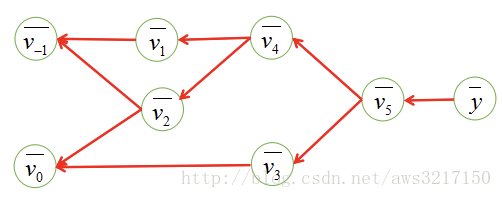

其具体计算过程如下表所示： 
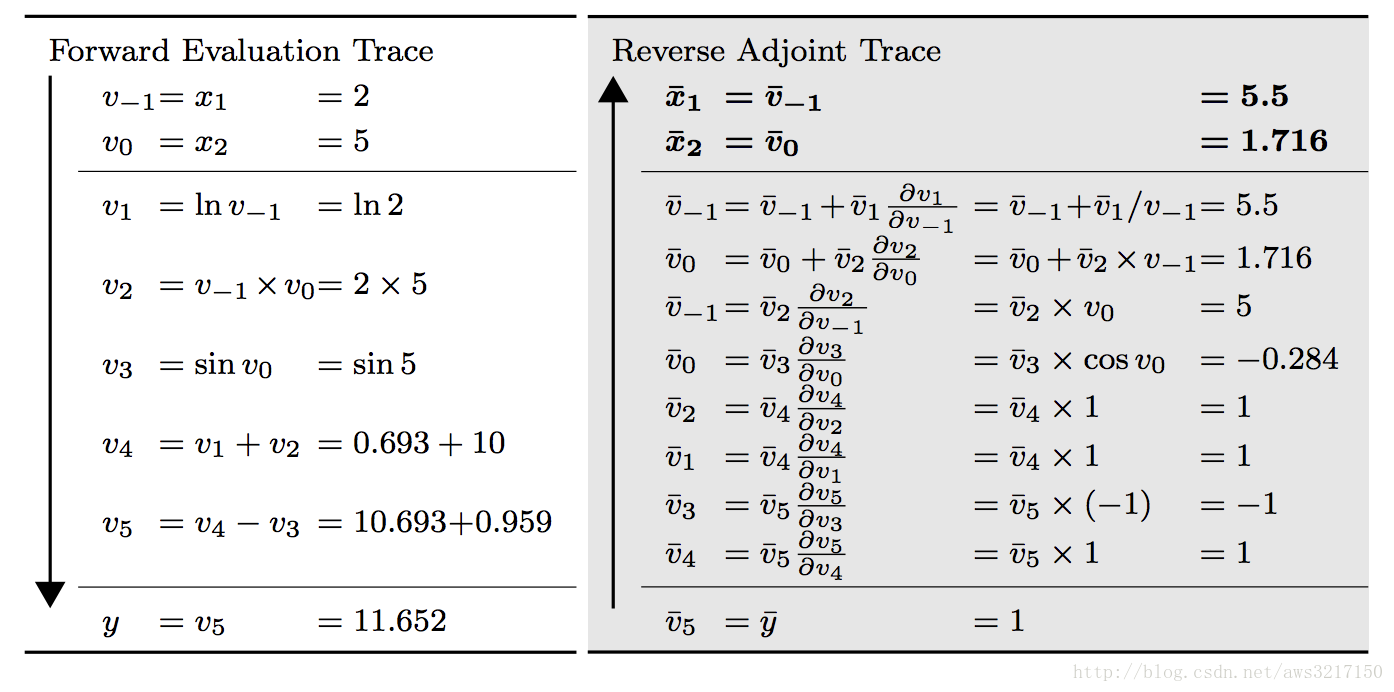
上表左边和之前的forward mode一致，用于求解函数值，右边则是reverse mode的计算过程，注意必须从下往上看，也就是一开始先计算输出y对于节点v5的导数，用$v^-$表示$\frac{dy}{dv5}$，这样的记号可以强调我们对当前计算结果进行缓存，以便用于后续计算，而不必重复计算。由链式法则我们可以计算输出对于每个节点的导数。 

和backprop算法一样，我们必须记住前向时当前节点发出的边，然后在后向传播的时候，可以搜集所有受到当前节点影响节点。 
如上的计算过程，对于像神经网络这种模型，通常输入是上万到上百万维，而输出损失函数是1维的模型，只需要一遍reverse mode的计算过程，便可以求出输出对于各个输入的导数，从而轻松求取梯度用于后续优化更新。

# 自动微分的实现
这里主要讲解reverse mode的实现方式，forward mode的实现基本和reverse mode一致，但是由于机器学习算法中大部分用reverse mode才可以高效求解，所以它是我们理解的重心。代码设计轮廓来源于CSE599G1的作业，通过分析完成作业，可以展示自动微分的简洁性和灵活可用性。
## Node
首先自动微分会将问题转化成一种有向无环图，因此我们必须构造基本的图部件，包括节点和边。可以先看看节点是如何实现的：
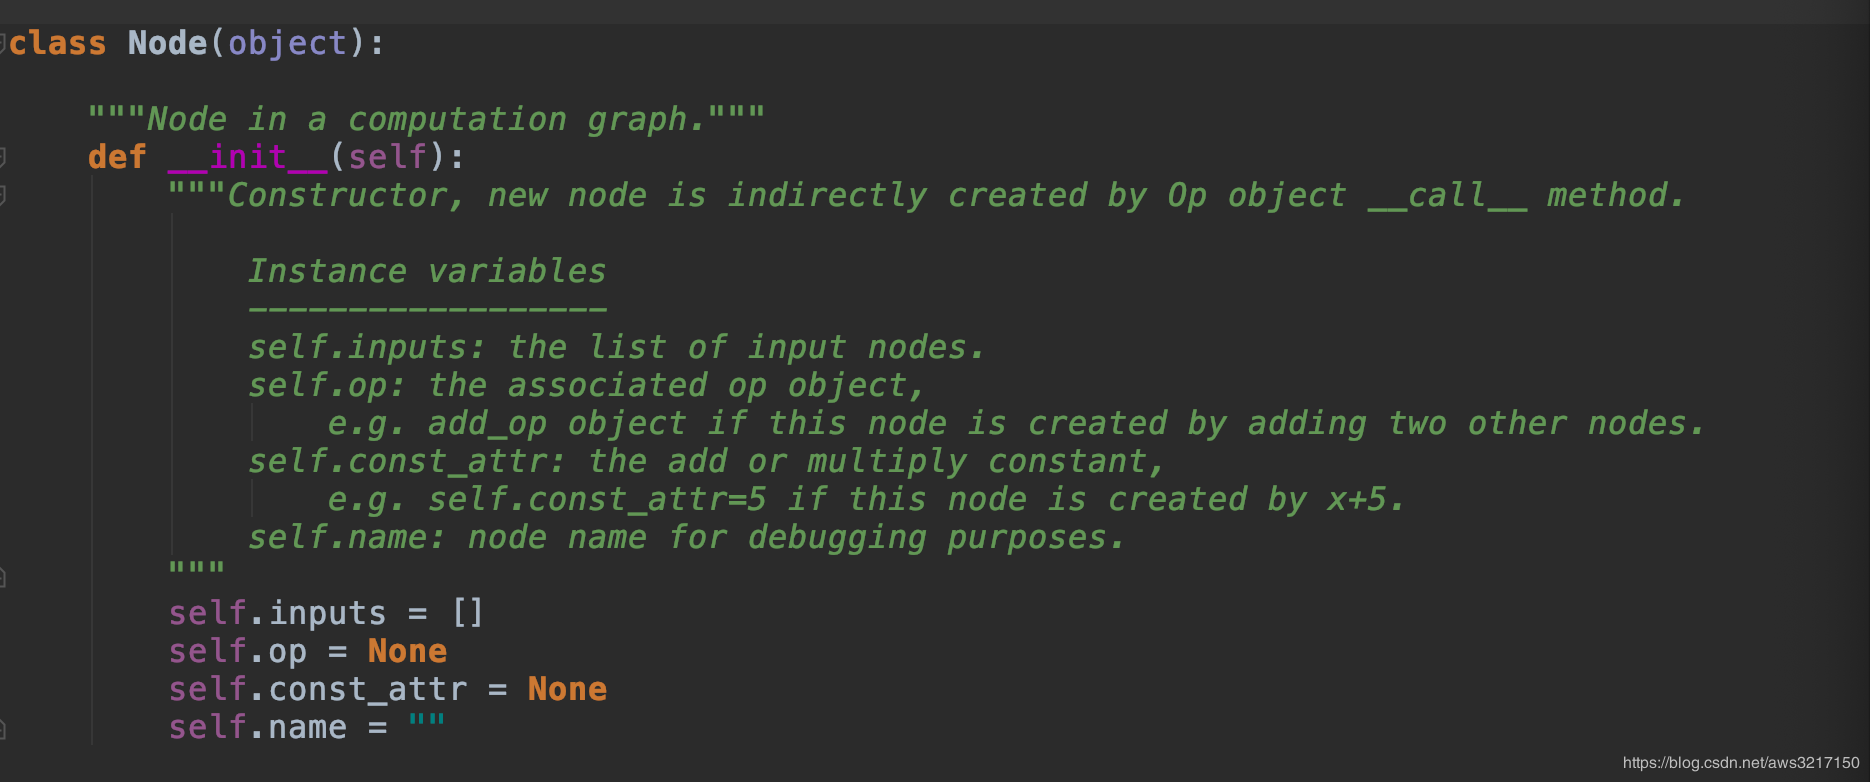


首先节点可以分为三种：

    常数节点
    变量节点
    带操作算子节点

因此Node类中定义了op成员用于存储节点的操作算子，const_attr代表节点的常数值，name是节点的标识，主要用于调试。
对于边的实现则简单的多，每个节点只要知道本身的输入节点即可，因此用inputs来描述节点的关系。
有了如上的定义，利用操作符重载，我们可以很简单构造一个计算图，举一个简单的例子：
$$f(x1,x2)=x1x2+x2$$

对于如上函数，只要重载加法和乘法操作符，我们可以轻松得到如下计算图：
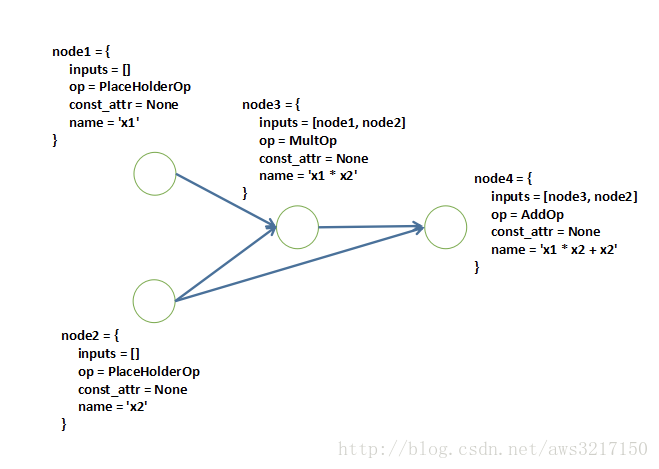

## Op
操作算子是自动微分最重要的组成部分，接下来我们重点介绍，先上代码：
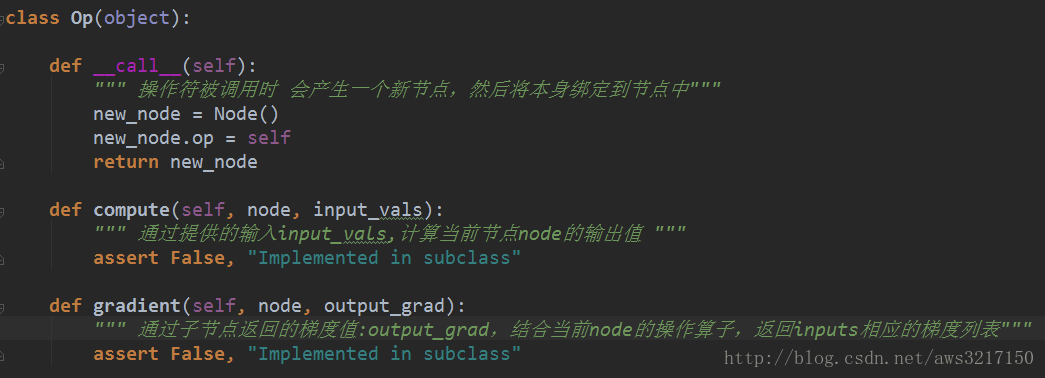
从定义可以看出，所有实际计算都落在各个操作算子中，上面代码应该抽象一些，我们来举一个乘法算子的例子加以说明：

### MulOp
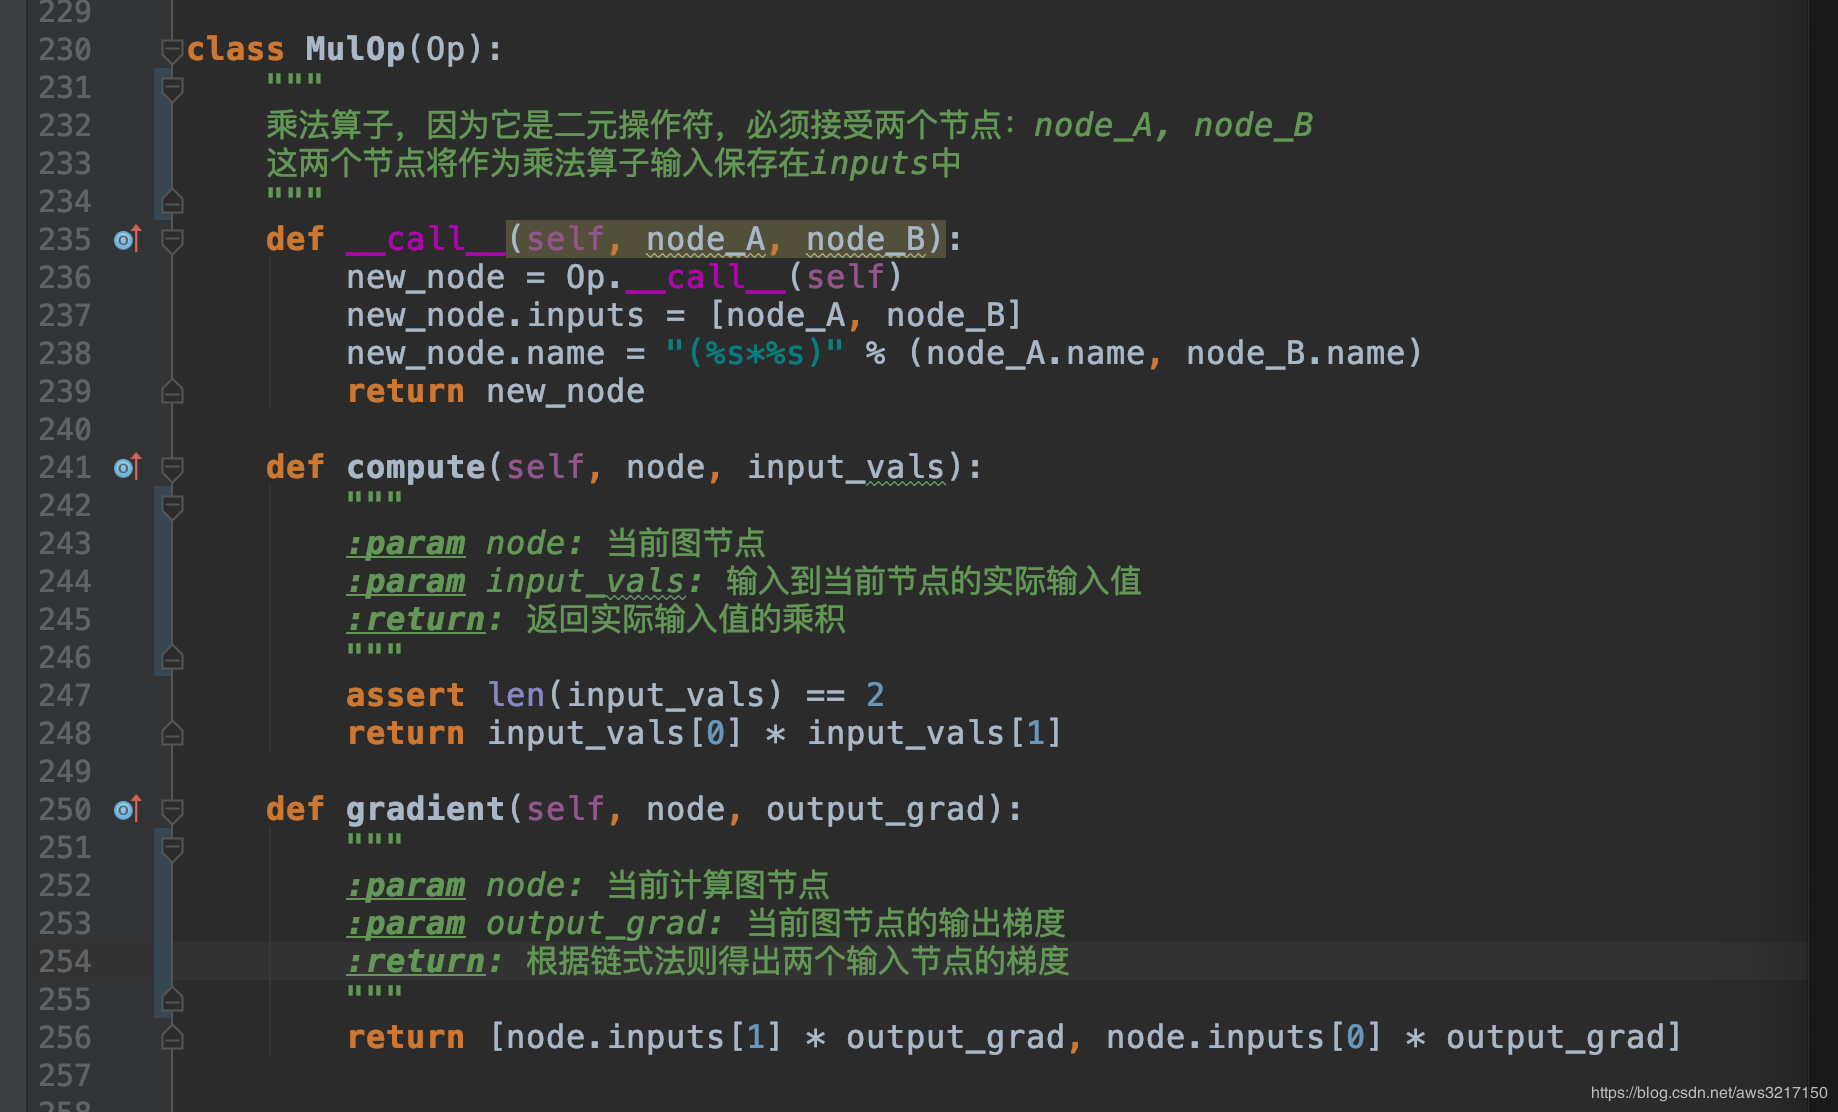

我们重点讲解一下gradient方法，它接收两个参数，一个是node，也就是当前要计算的节点，而output_grad则是后面节点传来的，我们来看看它到底是啥玩意，对于如下例子：
$$y=f(x1∗x2)$$
那么要求y关于x1的导数，那么根据链式法则可得：
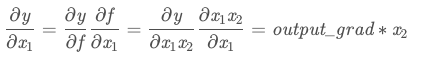

则output_grad就是上面的$\frac{∂y}{∂f}$，计算$y$对于$x2$类似。因此在程序中我们会返回如下：

`return [node.inputs[1] * output_grad, node.inputs[0] * output_grad]`

### PlaceHolderOp
再来介绍一个特殊的op——PlaceHolderOp，它的作用就如同名字，起到占位符的作用，也就是自动微分中的变量，它不会参与实际计算，只等待用户给他提供实际值，因此他的实现如下：
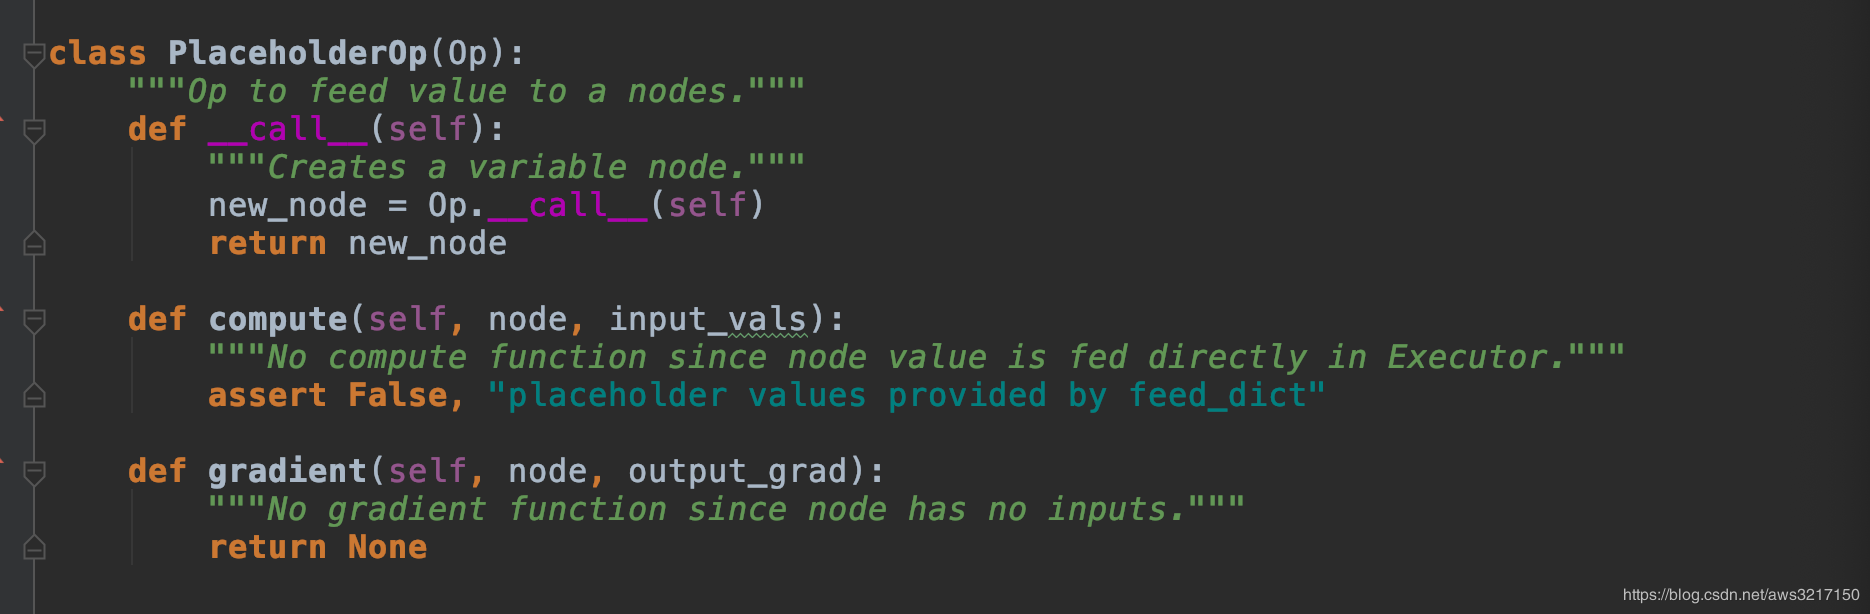

## Executor
了解了节点和操作算子的定义，接下来我们考虑如何协调执行运算。首先是如何计算函数值，对于一幅计算图，由于节点与节点之间的计算有一定的依赖关系，比如必须先计算node1之后才可以计算node2，那么如何能正确处理好计算关系呢？一个简单的方式是对图节点进行拓扑排序，这样可以保证需要先计算的节点先得到计算。这部分代码由Executor掌控：
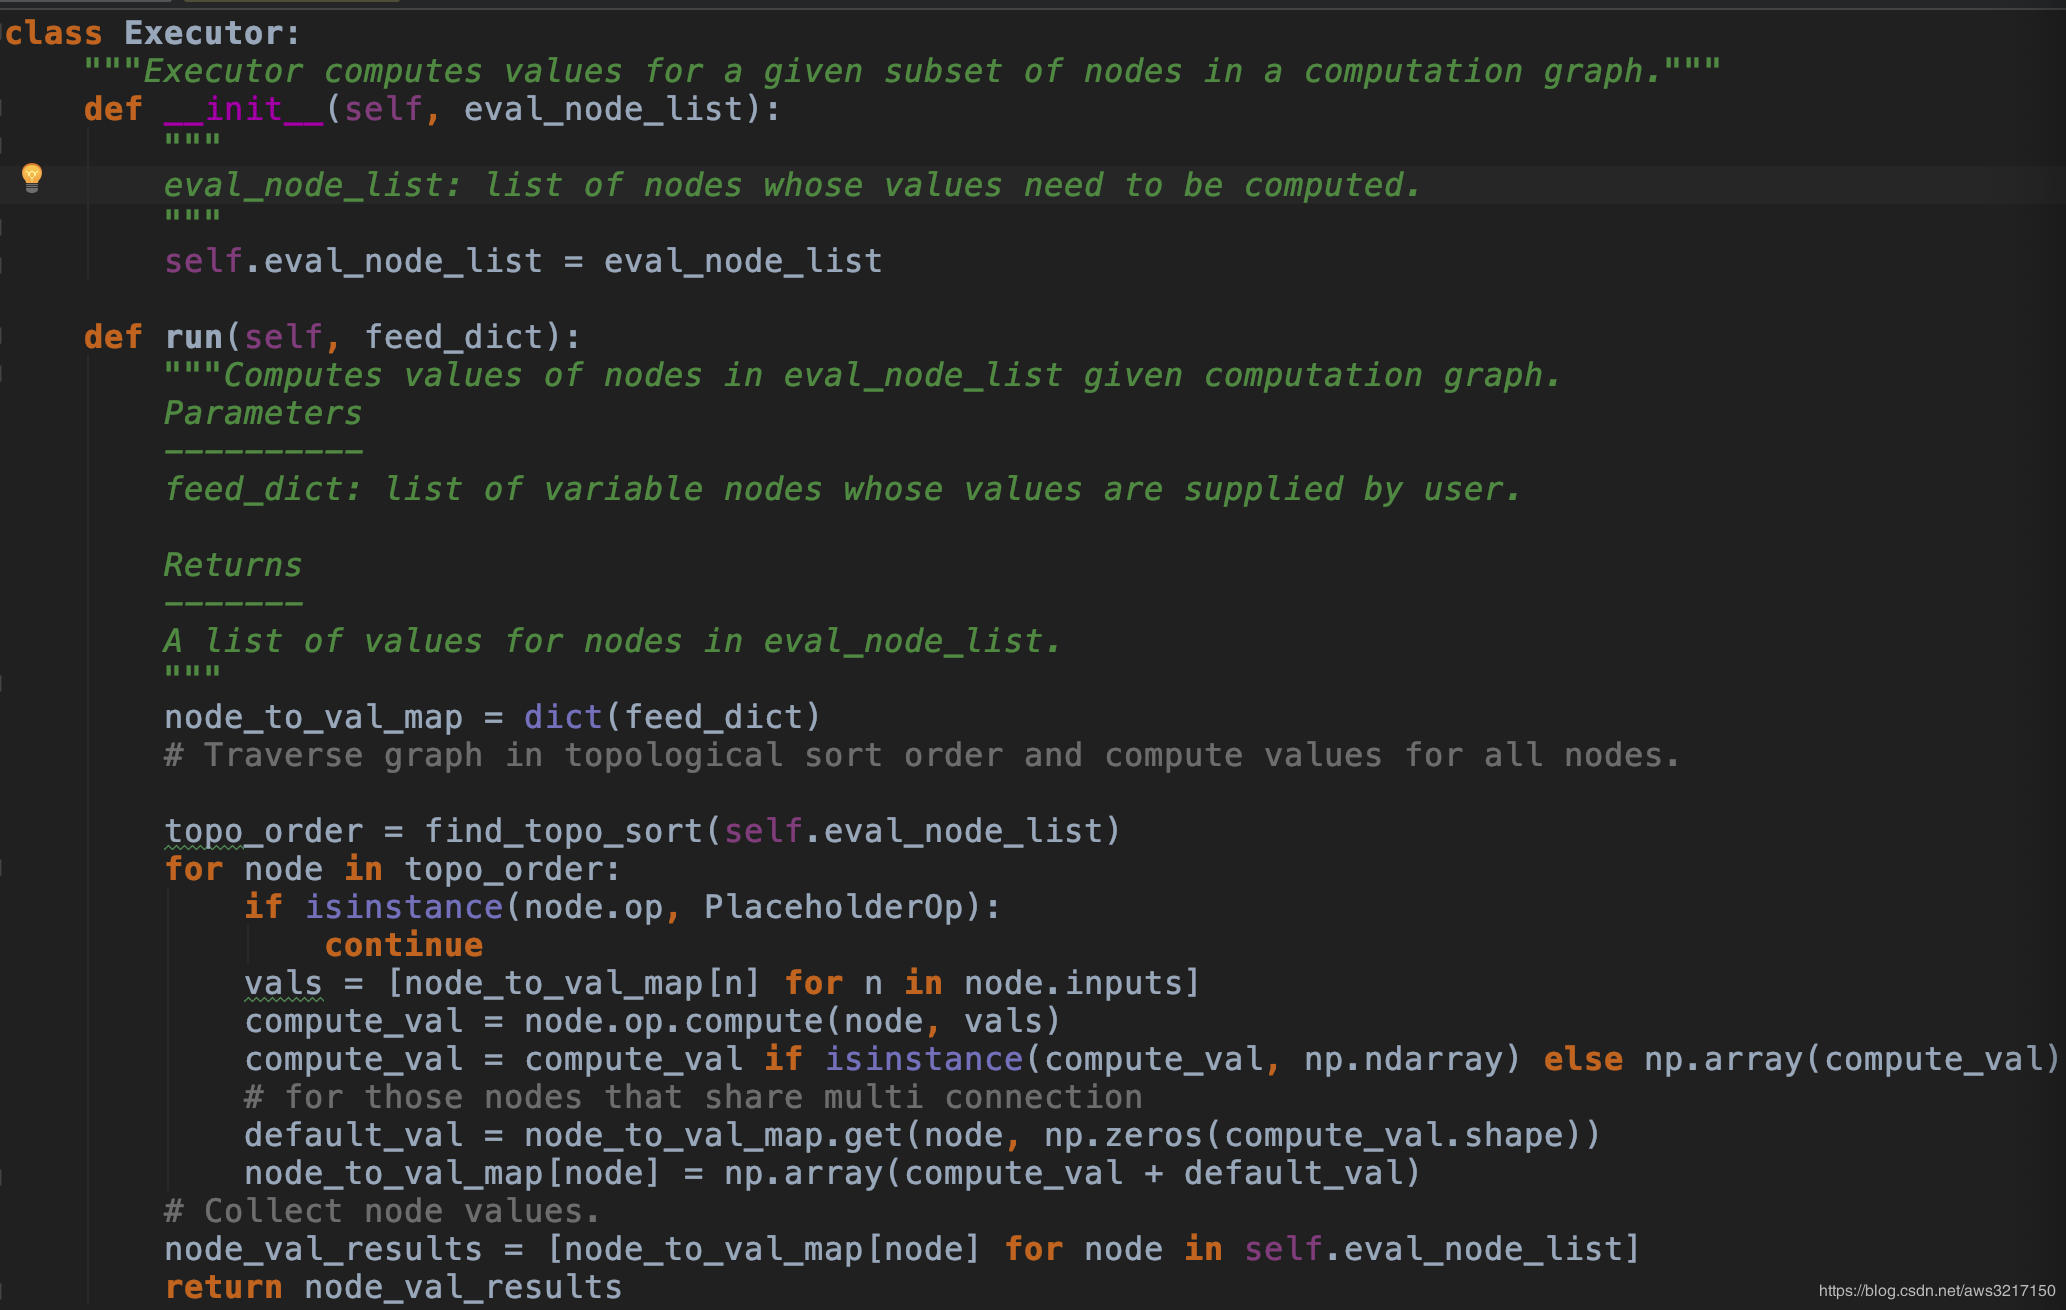

Executor是实际计算图的引擎，用户提供需要计算的图和实际输入，Executor计算相应的值和梯度。
## gradients
如何从计算图中计算函数的值，上面我们已经介绍了，接下来是如何自动计算梯度。reverse mode的自动微分，要求从输出到输入节点，按照先后依赖关系，对各个节点求取输出对于当前节点的梯度，那么和我们上面介绍的刚好相反，为了得到正确计算节点顺序，我们可以将图节点的拓扑排序倒序即可。代码也很简单，如下所示：
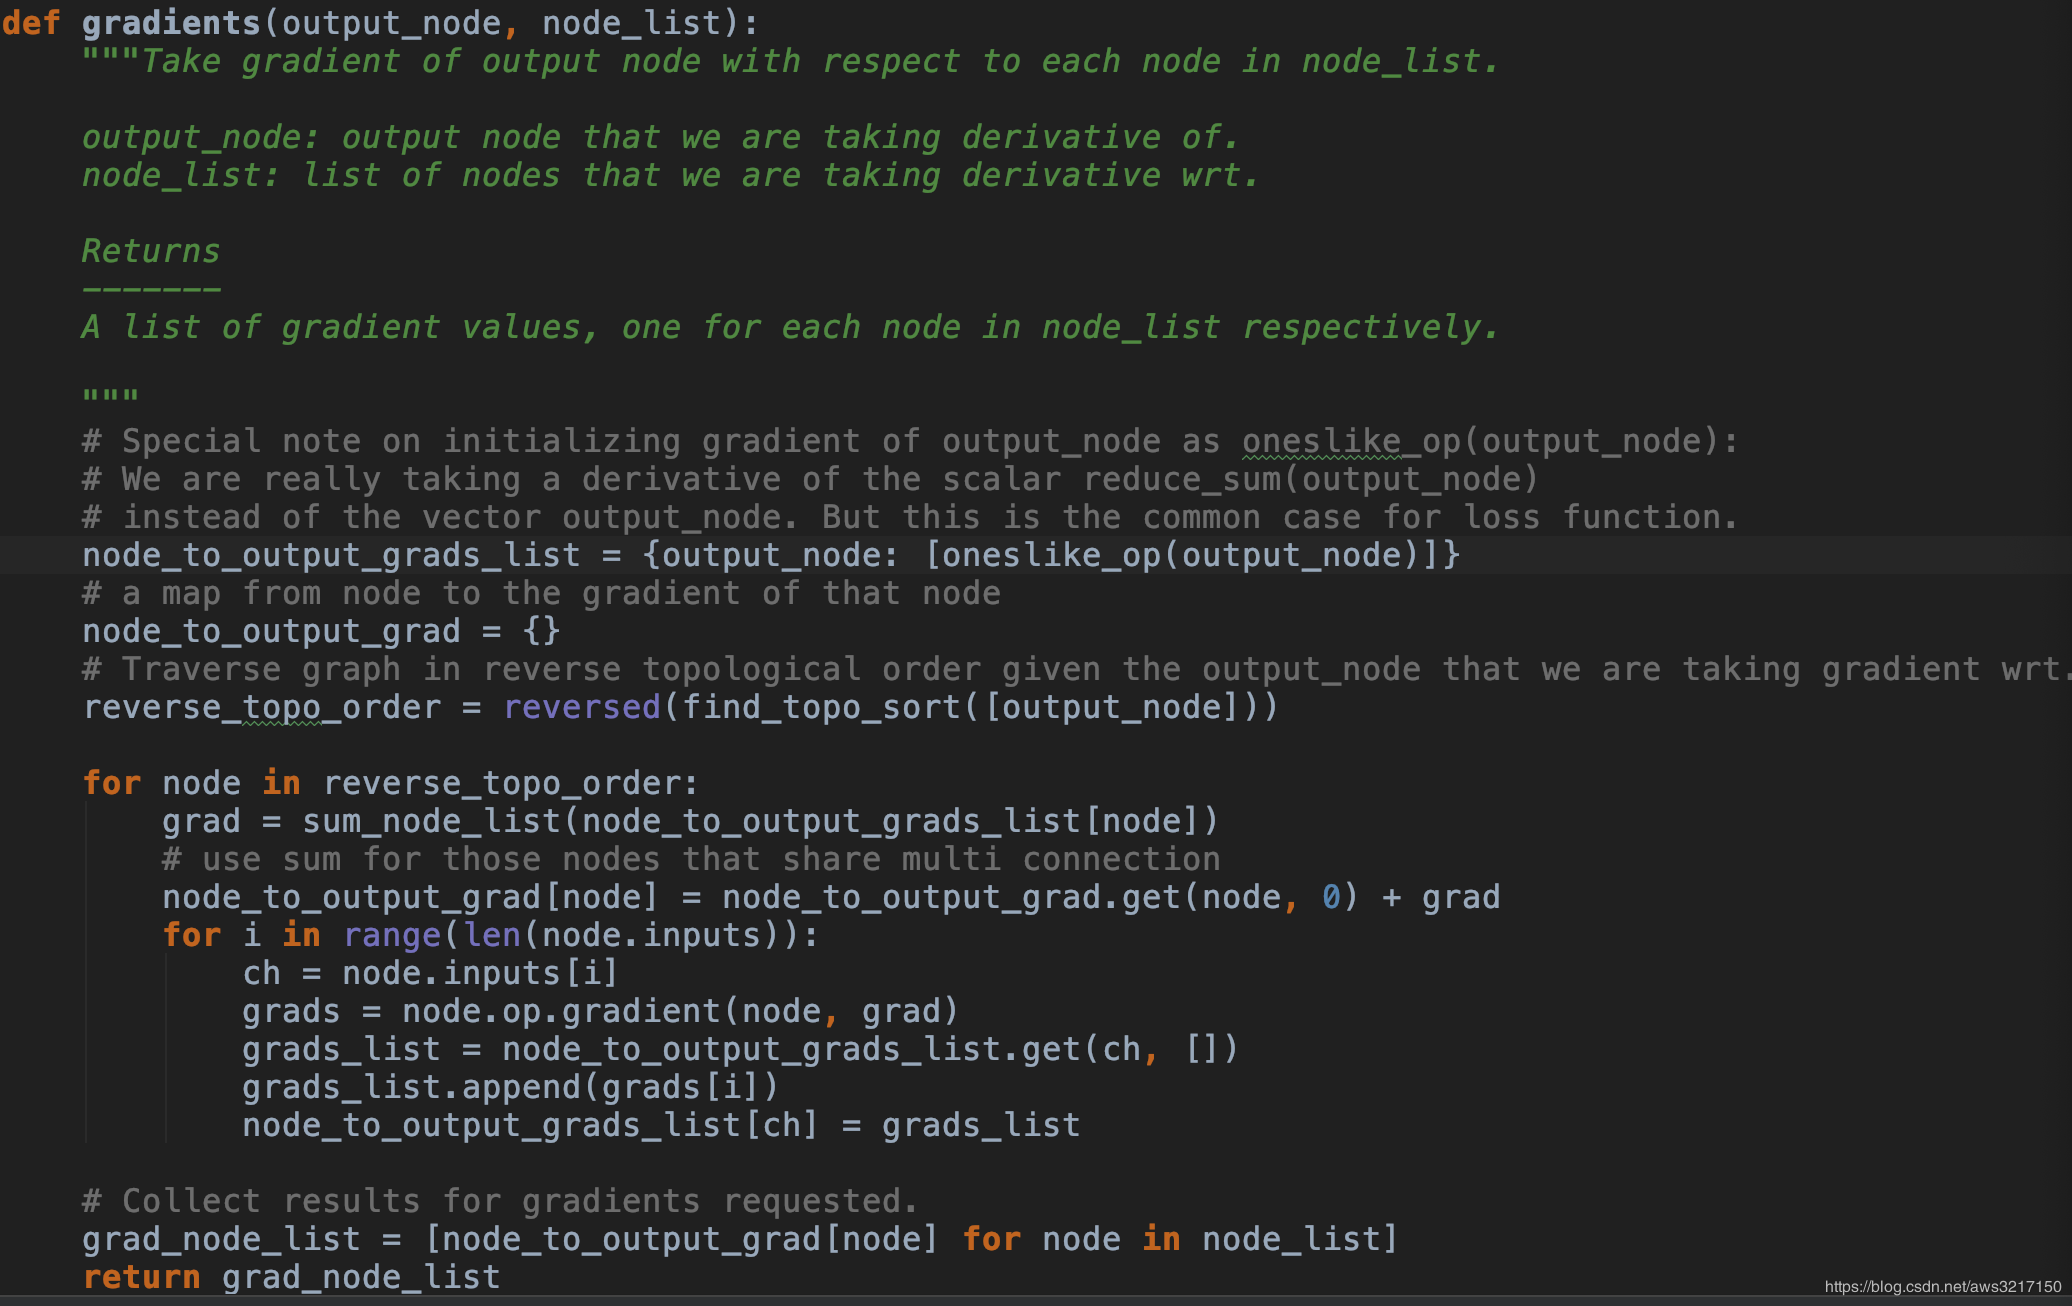

### oneslike_op
这里先介绍一个新的算子——oneslike_op。他是一个和numpy自带的oneslike函数一样的算子，作用是构造reverse梯度图的起点，因为最终输出关于本身的梯度就是一个和输出shape一样的全1数组，引入oneslike_op可以使得真实计算得以延后，因此gradients方法最终返回的不是真实的梯度，而是梯度计算图，然后可以复用Executor，计算实际的梯度值。

紧接着是根据输出节点，获得倒序的拓扑排序序列，然后遍历序列，构造实际的梯度计算图。我们重点来介绍node_to_output_grad和node_to_output_grads_list这两个字典的意义。

先关注node_to_output_grads_list，他key是节点，value是一个梯度列表，代表什么含义呢？先看如下部分计算图：

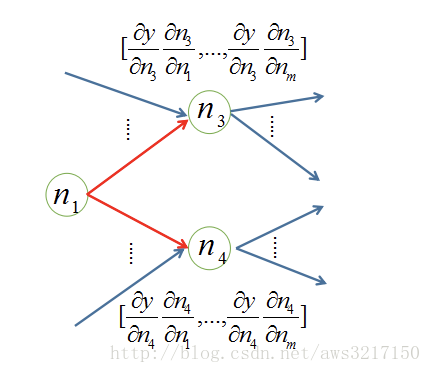

此时我们要计算输出y关于节点n1的导数，那么我们观察到他的发射边连接的节点有n3,n4，而对应n3,n4节点调用相应op的gradient方法，会返回输出yy关于各个输入节点的导数。此时为了准确计算输出yy关于节点n1的导数，我们需要将其发射边关联节点的计算梯度搜集起来，比如上面的例子，我们需要搜集：

....

# 自动微分的应用
有了上面的大篇幅介绍，我们其实已经实现了一个简单的自动微分引擎了，接下来看如何使用：
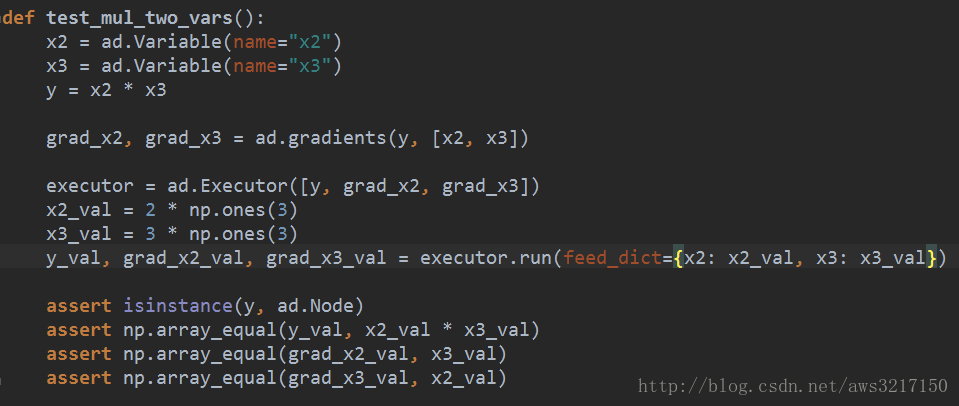

使用相当简单，我们像编写普通程序一样，对变量进行各种操作，只要提供要求导数的变量，还有提供实际输入，引擎可以正确给出相应的梯度值。

下面给出一个根据自动微分训练Logistic Regression的例子：